In [144]:
%matplotlib inline 

from os.path import join

from rasterio.plot import show
import rasterio
import matplotlib.pyplot as plt
import xmltodict
from shapely.geometry import Polygon
import numpy as np


In [145]:
data_dir = '/opt/data/nih-histo/eosinophil-data/'
img_path = join(data_dir, '32.tiff')
label_path = join(data_dir, '32-labels.tiff')
fov_path = join(data_dir, '32.xml')

scale = 8 

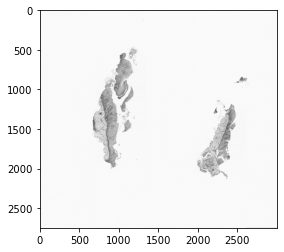

In [146]:
src = rasterio.open(img_path)
img_thumbnail = src.read(1, out_shape=(1, int(src.height // scale), int(src.width // scale)))
plt.imshow(img_thumbnail, cmap='gray')

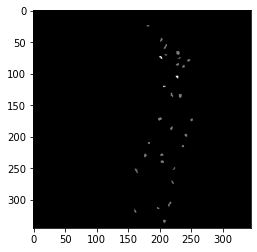

In [147]:
src = rasterio.open(label_path)
label_thumbnail = src.read(1, out_shape=(1, int(src.height // scale), int(src.width // scale)))
plt.imshow(label_thumbnail, cmap='gray')

In [48]:
! pip install xmltodict

In [155]:
with open(fov_path) as fd:
    fov_dict = xmltodict.parse(fd.read())
points = fov_dict['LayerData']['Regions']['Object'][1]['Vertices']['Vertex']
fov = [(float(p['@X']), float(p['@Y'])) for p in points]
fov = np.array(fov)
dots_per_mm = 5000
# negate the y dimension so that the value increases as we go down the array
fov[:, 1] *= -1

In [149]:
# These vertices described the blue dashed circle shown in the images above for #32 and #22076. These are expressed in millimeters where the center of the image is (0 mm, 0 mm) and the x-coordinate increases from left to right and the y-coordinate increases from bottom to top.
# How many millimeters are there per pixel? Once I have that piece of information, I should be able to translate these into pixel-based coordinates. I could not find this information precisely, but rather the dots/mm – with is 4000 dots/mm for the images labeled with 5 digits (ex: #22076) and 5000 dots/mm for the images labeled with 1 or 2 digits (ex: 32). Below is a copy of the image information for #22076, as an example.

In [157]:
height, width = img_thumbnail.shape
y_center, x_center = height // 2, width // 2
img_center = np.array([[x_center, y_center]])
img_center

array([[1500, 1375]])

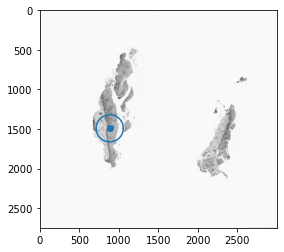

In [158]:
# multiply by scale factor so it's in pixel coordinates and then
# center the cicle: add the position of the center of the image
fov_poly = Polygon((fov * dots_per_mm / scale) + img_center)
plt.imshow(img_thumbnail, cmap='gray')
plt.plot(*fov_poly.exterior.xy)
plt.scatter(*fov_poly.centroid.xy)

In [164]:
label_overlay = np.zeros(img_thumbnail.shape)

In [165]:
fov_center = np.array(fov_poly.centroid.xy).squeeze()
fov_center

array([ 885.27573439, 1490.79074055])

In [166]:
label_height, label_width = label_thumbnail.shape
label_half_width = np.array([label_width / 2, label_height / 2])
label_offset = fov_center - label_half_width
label_offset = label_offset.astype(np.int32)
label_offset

array([ 712, 1318], dtype=int32)

In [167]:
label_overlay[
    label_offset[1]:label_offset[1] + label_thumbnail.shape[0], 
    label_offset[0]:label_offset[0] + label_thumbnail.shape[1]] = label_thumbnail 

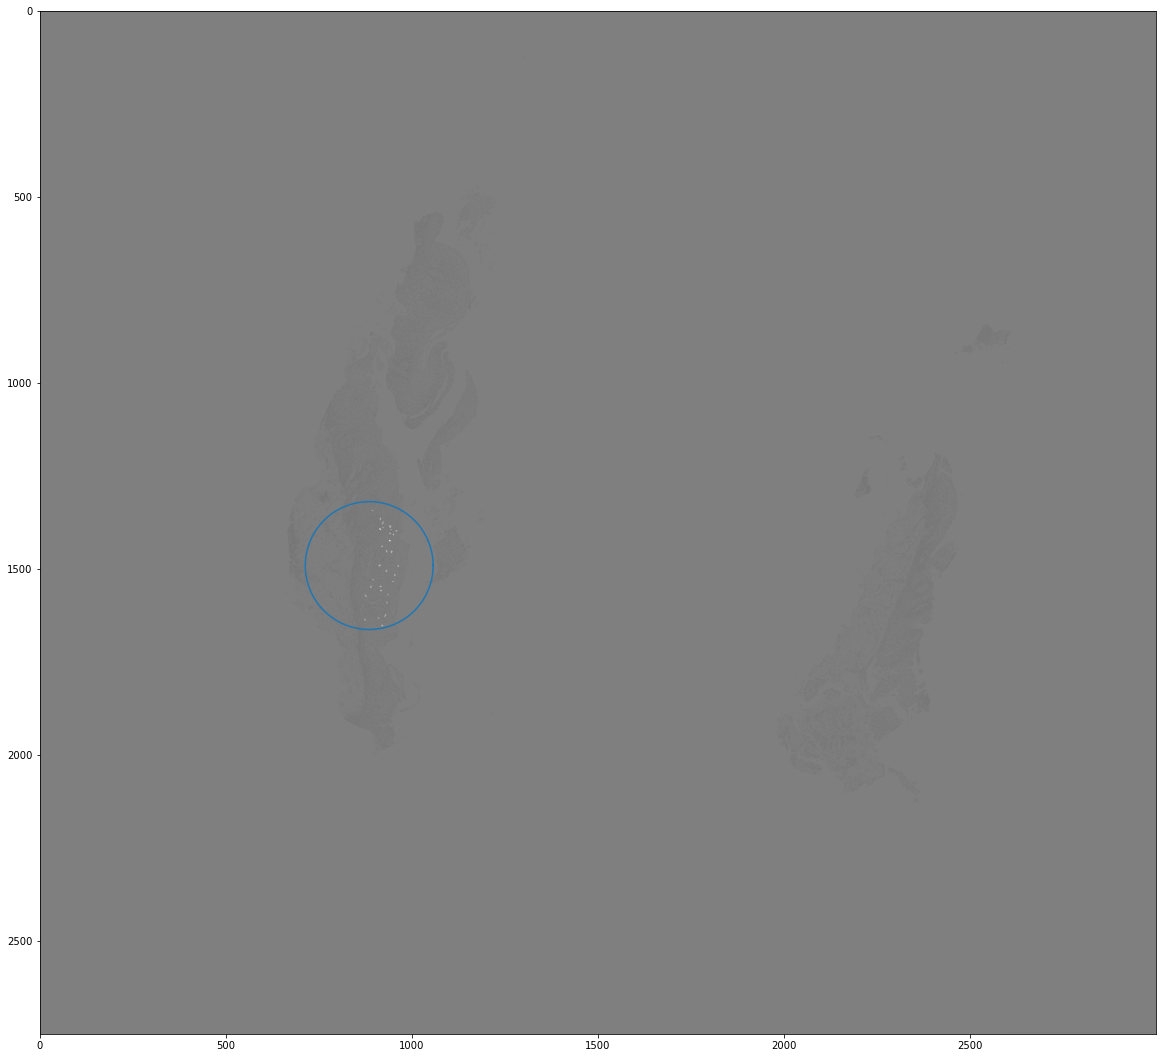

In [169]:
plt.rcParams['figure.figsize'] = [20, 20]

plt.imshow(img_thumbnail, cmap='gray', alpha=0.1)
plt.imshow(label_overlay, cmap='gray', vmin=0, vmax=2, alpha=0.5)
plt.plot(*fov_poly.exterior.xy)

In [ ]:
# do without scaling, then save label tiff to disk along with aoi in pixels coordinates in geojson file
# longitude and latitude x/y

